**Data Preparation & EDA**

In [17]:
# Étape 0 : Installation et import des librairies
!pip install pandas numpy matplotlib seaborn wordcloud nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import ast
import nltk
from nltk.corpus import stopwords
import re

# Télécharger les stopwords pour le nettoyage de texte
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# Étape 1 : Charger le CSV depuis Google Colab
from google.colab import files

uploaded = files.upload()  # Choisis ton fichier 'all_job_post (1).csv'

# Charger le DataFrame
df = pd.read_csv("all_job_post.csv")

# Aperçu des premières lignes
df.head()


Saving all_job_post.csv to all_job_post (1).csv


,job_id,category,job_title,job_description,job_skill_set
0,3902668440,HR,Sr Human Resource Generalist,SUMMARY\nTHE SR. HR GENERALIST PROVIDES HR EXP...,"['employee relations', 'talent acquisition', '..."
1,3905823748,HR,Human Resources Manager,BE PART OF A STELLAR TEAM AT YSB AS THE MANAGE...,"['Talent Acquisition', 'Employee Performance M..."
2,3905854799,HR,Director of Human Resources,OUR CLIENT IS A THRIVING ORGANIZATION OFFERING...,"['Human Resources Management', 'Recruitment', ..."
3,3905834061,HR,Chief Human Resources Officer,JOB TITLE: CHIEF HUMAN RESOURCES OFFICER (CHRO...,"['talent management', 'organizational developm..."
4,3906250451,HR,Human Resources Generalist (Hybrid Role),DESCRIPTION\n\n WHO WE ARE \n\nAVI-SPL IS A DI...,"['Microsoft Office', 'Data analysis', 'Employe..."


In [19]:
# Dimensions et types
print("Shape:", df.shape)
print("\nTypes de données:")
print(df.dtypes)

# Vérifier les valeurs manquantes
print("\nValeurs manquantes:")
print(df.isnull().sum())

# Aperçu des colonnes
print("\nColonnes:", df.columns.tolist())


Shape: (1167, 5)

Types de données:
job_id              int64
category           object
job_title          object
job_description    object
job_skill_set      object
dtype: object

Valeurs manquantes:
job_id             0
category           0
job_title          0
job_description    0
job_skill_set      0
dtype: int64

Colonnes: ['job_id', 'category', 'job_title', 'job_description', 'job_skill_set']


In [20]:
# Nettoyage des descriptions
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['job_description_clean'] = df['job_description'].apply(clean_text)

# Conversion de job_skill_set de string → liste
df['job_skill_set'] = df['job_skill_set'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# Normalisation des noms de compétences
df['job_skill_set'] = df['job_skill_set'].apply(lambda skills: [s.lower().strip() for s in skills])


In [21]:
# Nombre de compétences par job
df['n_skills'] = df['job_skill_set'].apply(len)

print("Nombre moyen de compétences par job :", df['n_skills'].mean())
print("Nombre max de compétences :", df['n_skills'].max())

# Création d'une liste de toutes les compétences
all_skills = [skill for skills in df['job_skill_set'] for skill in skills]

# Compter les occurrences
from collections import Counter
skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(10)

# Affichage des 10 compétences les plus fréquentes
print("\nTop 10 compétences les plus fréquentes:")
for skill, count in top_skills:
    print(f"{skill}: {count}")


Nombre moyen de compétences par job : 17.851756640959724
Nombre max de compétences : 43

Top 10 compétences les plus fréquentes:
communication: 1092
problem solving: 878
adaptability: 588
teamwork: 569
collaboration: 341
leadership: 325
time management: 316
interpersonal skills: 288
customer service: 272
relationship building: 267


/tmp/ipython-input-1663882287.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['category'], order=df['category'].value_counts().index, palette="viridis")


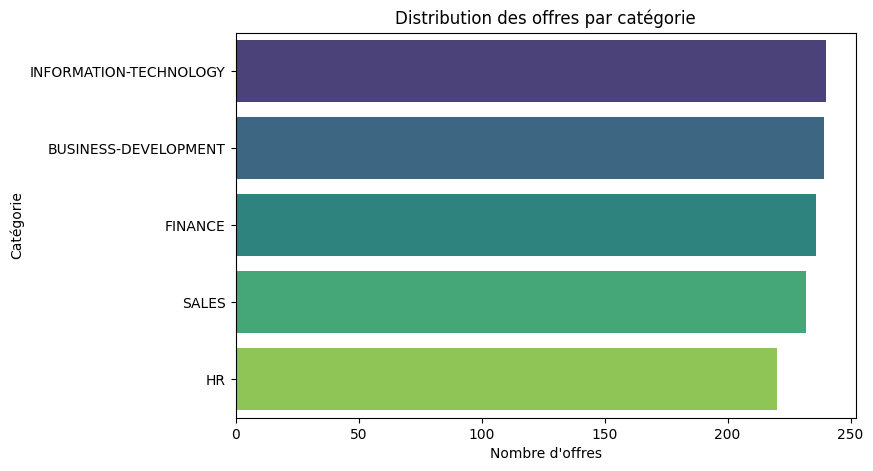

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(y=df['category'], order=df['category'].value_counts().index, palette="viridis")
plt.title("Distribution des offres par catégorie")
plt.xlabel("Nombre d'offres")
plt.ylabel("Catégorie")
plt.show()


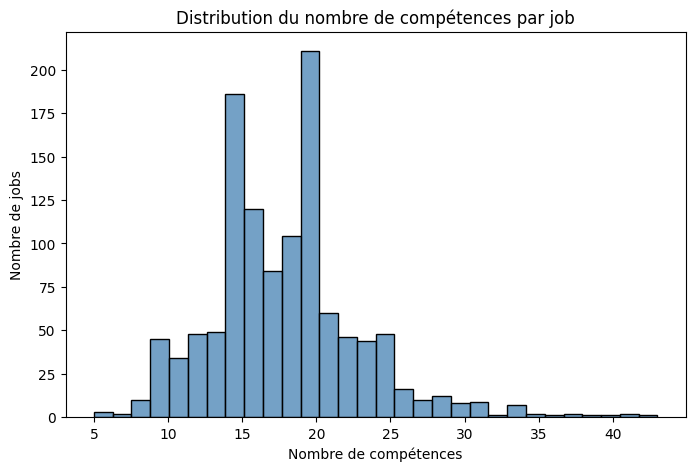

In [23]:
plt.figure(figsize=(8,5))
sns.histplot(df['n_skills'], bins=30, color='steelblue')
plt.title("Distribution du nombre de compétences par job")
plt.xlabel("Nombre de compétences")
plt.ylabel("Nombre de jobs")
plt.show()


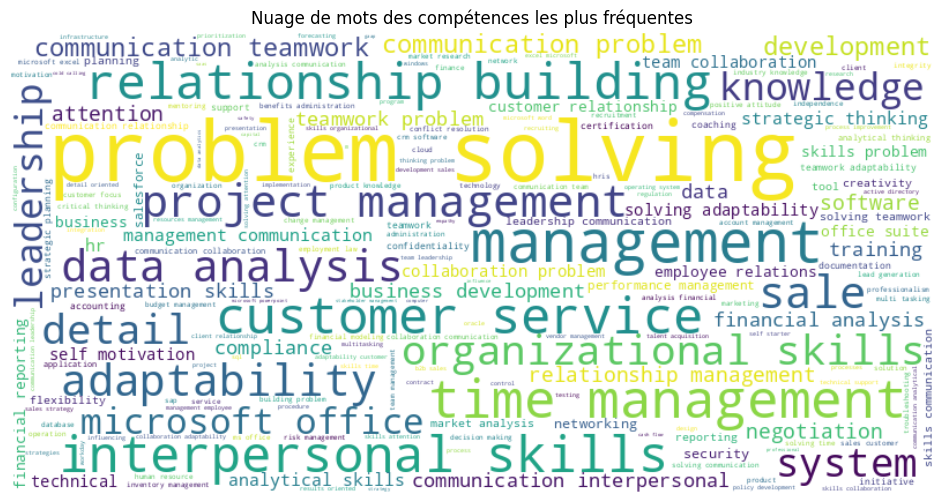

In [24]:
text_skills = " ".join(all_skills)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_skills)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots des compétences les plus fréquentes")
plt.show()


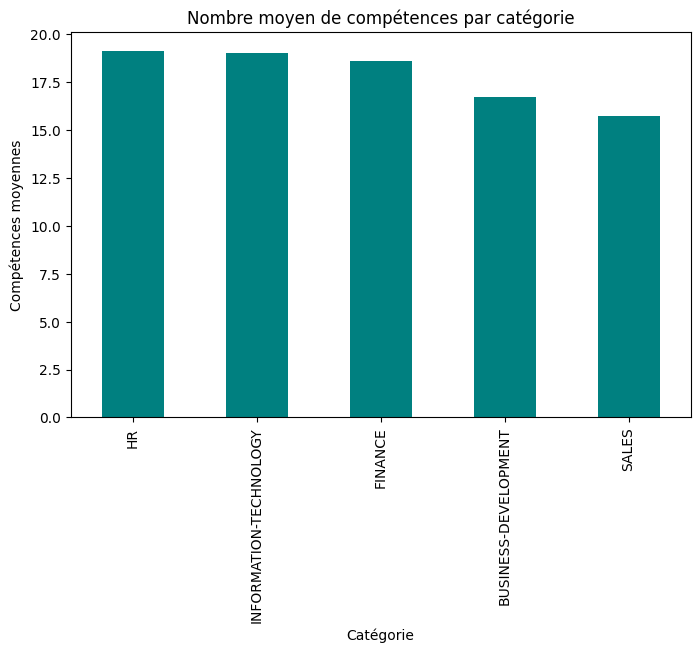

In [25]:
# Moyenne de compétences par catégorie
category_skills = df.groupby('category')['n_skills'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
category_skills.plot(kind='bar', color='teal')
plt.title("Nombre moyen de compétences par catégorie")
plt.ylabel("Compétences moyennes")
plt.xlabel("Catégorie")
plt.show()


In [26]:
df.to_csv("cleaned_jobs.csv", index=False)
files.download("cleaned_jobs.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!pip install neo4j py2neo sentence-transformers tqdm

In [3]:
from py2neo import Graph, Node, Relationship
from tqdm import tqdm
import pandas as pd
import ast


from faker import Faker
from collections import Counter

# -------------------------
# ⚙️  CONFIGURATION
# -------------------------
graph = Graph(
    "neo4j+s://f2e325e6.databases.neo4j.io",
    auth=("neo4j", "Tas8DQsuJnRLyWSXJpb6DH9weNBlE5rRZdG-d2NfZPs")
)

fake = Faker(['fr_FR', 'en_US'])
Faker.seed(42)

In [7]:
from faker import Faker
fake = Faker(['fr_FR', 'en_US'])
print(fake.name())

Gabriel de Guilbert


In [8]:
graph.run("MATCH (n) DETACH DELETE n")


(No data)

In [14]:

# -------------------------
# 🧹 CHARGEMENT ET NETTOYAGE DES DONNÉES
# -------------------------
print("🔄 CHARGEMENT DES DONNÉES...")
df_original = pd.read_csv("all_job_post.csv")

print("🧹 NETTOYAGE INTELLIGENT DES COMPÉTENCES...")

def proper_skill_cleaning(skill_str):
    try:
        if isinstance(skill_str, str):
            skills = ast.literal_eval(skill_str)
        else:
            skills = skill_str

        cleaned = []
        for skill in skills:
            skill_clean = str(skill).strip().lower()
            if (
                len(skill_clean) >= 2 and
                skill_clean not in ['', '.', '..', '...', 'n/a', 'none'] and
                not skill_clean.isdigit()
            ):
                cleaned.append(skill_clean)
        return cleaned
    except:
        return []

df_original['job_skill_set_clean'] = df_original['job_skill_set'].apply(proper_skill_cleaning)

print(f"✅ Exemple de nettoyage :")
sample_idx = 0
print(f"Avant : {df_original['job_skill_set'].iloc[sample_idx]}")
print(f"Après : {df_original['job_skill_set_clean'].iloc[sample_idx]}")

# -------------------------
# 📊 STATISTIQUES RAPIDES
# -------------------------
all_skills_clean = [skill for skills in df_original['job_skill_set_clean'] for skill in skills]
skill_counts = Counter(all_skills_clean)

print(f"📈 Skills totaux : {len(all_skills_clean)}")
print(f"📈 Skills uniques : {len(skill_counts)}")
print("📊 Top 10 compétences :")
for s, c in skill_counts.most_common(10):
    print(f"  - {s}: {c}")

# -------------------------
# 🗑️  RÉINITIALISATION DU GRAPHE
# -------------------------
print("\n🧨 SUPPRESSION DES DONNÉES EXISTANTES...")
graph.run("MATCH (n) DETACH DELETE n")

graph.run("CREATE CONSTRAINT job_id_unique IF NOT EXISTS FOR (j:Job) REQUIRE j.job_id IS UNIQUE")
graph.run("CREATE CONSTRAINT skill_name_unique IF NOT EXISTS FOR (s:Skill) REQUIRE s.skill_name IS UNIQUE")
graph.run("CREATE CONSTRAINT emp_name_unique IF NOT EXISTS FOR (e:Employee) REQUIRE e.name IS UNIQUE")

# -------------------------
# 👔 CRÉATION DES JOBS
# -------------------------
print("\n👔 CRÉATION DES JOBS...")
job_nodes = [
    {
        'job_id': int(row['job_id']),
        'title': row['job_title'],
        'category': row['category']
    }
    for _, row in df_original.iterrows()
]

graph.run("""
    UNWIND $jobs AS job
    CREATE (j:Job {job_id: job.job_id, title: job.title, category: job.category})
""", jobs=job_nodes)

print(f"✅ {len(job_nodes)} jobs créés.")

# -------------------------
# 🛠️  CRÉATION DES SKILLS
# -------------------------
print("\n🛠️  CRÉATION DES SKILLS...")
unique_skills = list(set(all_skills_clean))
print(f"📦 {len(unique_skills)} compétences uniques à créer...")

batch_size = 500
for i in tqdm(range(0, len(unique_skills), batch_size), desc="Création Skills"):
    batch = [{'skill_name': s} for s in unique_skills[i:i+batch_size]]
    graph.run("""
        UNWIND $skills AS skill
        MERGE (s:Skill {skill_name: skill.skill_name})
    """, skills=batch)

# -------------------------
# 🔗 CRÉATION DES RELATIONS JOB → SKILL
# -------------------------
print("\n🔗 LIEN DES JOBS AVEC LES COMPÉTENCES...")
batch_size = 300
relations = []
for _, row in tqdm(df_original.iterrows(), total=len(df_original), desc="Préparation relations"):
    for skill in row['job_skill_set_clean']:
        relations.append({'job_id': int(row['job_id']), 'skill_name': skill})

for i in tqdm(range(0, len(relations), batch_size), desc="Création relations"):
    batch = relations[i:i + batch_size]
    graph.run("""
        UNWIND $rels AS rel
        MATCH (j:Job {job_id: rel.job_id})
        MATCH (s:Skill {skill_name: rel.skill_name})
        MERGE (j)-[:REQUIRES]->(s)
    """, rels=batch)

# -------------------------
# 👥 CRÉATION DES EMPLOYÉS (avec noms réalistes)
# -------------------------
print("\n👥 GÉNÉRATION D'EMPLOYÉS INTERNES...")
num_employees = min(300, len(df_original))  # limite pour éviter surcharge

# Sélectionner des jobs aléatoires pour associer à des employés
df_sample = df_original.sample(num_employees, random_state=42)

employees = []
for _, row in df_sample.iterrows():
    emp_name = fake.first_name() + " " + fake.last_name()
    employees.append({
        'name': emp_name,
        'role': row['job_title'],
        'category': row['category'],
        'skills': row['job_skill_set_clean']
    })

# Insertion des employés dans Neo4j
for e in tqdm(employees, desc="Création employés"):
    emp_node = Node("Employee", name=e['name'], role=e['role'], category=e['category'])
    graph.merge(emp_node, "Employee", "name")
    for skill in e['skills']:
        skill_node = Node("Skill", skill_name=skill)
        graph.merge(skill_node, "Skill", "skill_name")
        graph.merge(Relationship(emp_node, "HAS_SKILL", skill_node))

print(f"✅ {len(employees)} employés créés avec leurs compétences.")

# -------------------------
# 📊 VÉRIFICATION FINALE
# -------------------------
print("\n🎯 VÉRIFICATION FINALE DU GRAPHE :")
final_jobs = graph.run("MATCH (j:Job) RETURN count(j) as c").data()[0]['c']
final_skills = graph.run("MATCH (s:Skill) RETURN count(s) as c").data()[0]['c']
final_emps = graph.run("MATCH (e:Employee) RETURN count(e) as c").data()[0]['c']
final_rels = graph.run("MATCH ()-[r]->() RETURN count(r) as c").data()[0]['c']

print(f"📊 Jobs : {final_jobs}")
print(f"📊 Skills : {final_skills}")
print(f"📊 Employés : {final_emps}")
print(f"📊 Relations : {final_rels}")

# Vérification rapide d'un échantillon
print("\n🧪 EXEMPLE D'EMPLOYÉ :")
sample_emp = graph.run("""
    MATCH (e:Employee)-[:HAS_SKILL]->(s)
    RETURN e.name as name, e.role as role, e.category as category,
           collect(s.skill_name)[0..5] as skills
    LIMIT 1
""").data()[0]
print(sample_emp)

print("\n🌈 RÉUSSITE ! Graphe complet avec Employés internes + Compétences.")


🔄 CHARGEMENT DES DONNÉES...
🧹 NETTOYAGE INTELLIGENT DES COMPÉTENCES...
✅ Exemple de nettoyage :
Avant : ['employee relations', 'talent acquisition', 'performance management', 'compensation and benefits', 'employment laws and regulations', 'analytical skills', 'employee benefits administration', 'HR policies and procedures', 'recruitment strategies', 'FMLA', 'ADA', 'communication', 'interpersonal skills', 'collaboration', 'influence', 'change management', 'professional development', 'payroll processing', 'job design', 'salary administration', 'human capital management system', 'HR audits and assessments', 'FLSA', 'ERISA', 'EEOC guidelines', 'confidentiality', 'intellectual curiosity']
Après : ['employee relations', 'talent acquisition', 'performance management', 'compensation and benefits', 'employment laws and regulations', 'analytical skills', 'employee benefits administration', 'hr policies and procedures', 'recruitment strategies', 'fmla', 'ada', 'communication', 'interpersonal skil

Création Skills: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]



🔗 LIEN DES JOBS AVEC LES COMPÉTENCES...


Création relations: 100%|██████████| 70/70 [00:06<00:00, 10.53it/s]



👥 GÉNÉRATION D'EMPLOYÉS INTERNES...


Création employés: 100%|██████████| 300/300 [34:27<00:00,  6.89s/it]


✅ 300 employés créés avec leurs compétences.

🎯 VÉRIFICATION FINALE DU GRAPHE :
📊 Jobs : 1167
📊 Skills : 4982
📊 Employés : 300
📊 Relations : 26258

🧪 EXEMPLE D'EMPLOYÉ :
{'name': 'Nathalie Labbé', 'role': 'Business Development Manager - Dallas/Fort Worth', 'category': 'BUSINESS-DEVELOPMENT', 'skills': ['sales', 'product knowledge (swimming pool equipment)', 'analytical thinking', 'networking', 'team coordination']}

🌈 RÉUSSITE ! Graphe complet avec Employés internes + Compétences.


In [15]:
# 1. TEST AVANCÉ DU GRAPHE
print("🧪 TESTS AVANCÉS DU GRAPHE:")

# Test de requêtes complexes
test_queries = [
    # Trouver les skills les plus demandés
    """
    MATCH (s:Skill)<-[:REQUIRES]-(j:Job)
    RETURN s.skill_name as skill, COUNT(j) as demand
    ORDER BY demand DESC
    LIMIT 10
    """,

    # Trouver des chemins de reskilling
    """
    MATCH (s1:Skill {skill_name: 'communication'})<-[:REQUIRES]-(j:Job)-[:REQUIRES]->(s2:Skill)
    WHERE s1 <> s2
    RETURN s2.skill_name as related_skill, COUNT(j) as strength
    ORDER BY strength DESC
    LIMIT 10
    """,

    # Analyse par catégorie
    """
    MATCH (j:Job)-[:REQUIRES]->(s:Skill)
    WHERE j.category = 'INFORMATION-TECHNOLOGY'
    RETURN s.skill_name as skill, COUNT(*) as frequency
    ORDER BY frequency DESC
    LIMIT 10
    """
]

for i, query in enumerate(test_queries):
    print(f"\n🔍 Test {i+1}:")
    results = graph.run(query).data()
    for result in results[:5]:
        print(f"   {result}")

🧪 TESTS AVANCÉS DU GRAPHE:

🔍 Test 1:
   {'skill': 'communication', 'demand': 1092}
   {'skill': 'problem solving', 'demand': 878}
   {'skill': 'adaptability', 'demand': 588}
   {'skill': 'teamwork', 'demand': 569}
   {'skill': 'collaboration', 'demand': 341}

🔍 Test 2:
   {'related_skill': 'problem solving', 'strength': 842}
   {'related_skill': 'adaptability', 'strength': 565}
   {'related_skill': 'teamwork', 'strength': 549}
   {'related_skill': 'collaboration', 'strength': 323}
   {'related_skill': 'leadership', 'strength': 311}

🔍 Test 3:
   {'skill': 'communication', 'frequency': 219}
   {'skill': 'problem solving', 'frequency': 191}
   {'skill': 'adaptability', 'frequency': 112}
   {'skill': 'teamwork', 'frequency': 101}
   {'skill': 'collaboration', 'frequency': 88}


In [16]:
class SmartReskillingRecommender:
    def __init__(self, graph):
        self.graph = graph
        self.data_quality_threshold = 3  # Minimum de jobs pour considérer les données fiables

    def analyze_market_data_quality(self, target_roles, target_category=None):
        """Analyse la qualité des données de marché disponibles"""
        print("🔍 ANALYSE DE LA QUALITÉ DES DONNÉES:")

        if target_roles:
            role_analysis = []
            for role in target_roles:
                query = """
                MATCH (j:Job)
                WHERE toLower(j.title) CONTAINS toLower($role)
                RETURN COUNT(j) as job_count
                """
                result = self.graph.run(query, role=role).data()
                job_count = result[0]['job_count'] if result else 0
                role_analysis.append((role, job_count))

            print(f"📊 Rôles analysés: {role_analysis}")

            # Filtrer seulement les rôles avec suffisamment de données
            valid_roles = [role for role, count in role_analysis if count >= self.data_quality_threshold]
            insufficient_roles = [role for role, count in role_analysis if count < self.data_quality_threshold]

            if insufficient_roles:
                print(f"⚠️  Données insuffisantes pour: {insufficient_roles}")

            return valid_roles, role_analysis

        elif target_category:
            query = """
            MATCH (j:Job {category: $category})
            RETURN COUNT(j) as job_count
            """
            result = self.graph.run(query, category=target_category).data()
            job_count = result[0]['job_count'] if result else 0

            print(f"📊 Catégorie '{target_category}': {job_count} jobs")

            if job_count >= self.data_quality_threshold:
                return [target_category], [(target_category, job_count)]
            else:
                return [], [(target_category, job_count)]

        return [], []

    def get_employee_profile(self, current_skills, experience_years=3, current_role=""):
        return {
            'current_skills': [s.lower().strip() for s in current_skills],
            'experience_years': experience_years,
            'current_role': current_role,
            'skill_count': len(current_skills)
        }

    def smart_recommendation(self, employee_profile, target_roles=None, target_category=None, fallback_strategy="broad_category"):
        """
        Recommandation intelligente qui s'adapte à la qualité des données
        """
        print(f"\n🎯 DEMANDE DE RECOMMANDATION INTELLIGENTE")
        print(f"   Employé: {employee_profile['current_role']}")
        print(f"   Compétences actuelles: {employee_profile['skill_count']}")

        # Étape 1: Analyse de la qualité des données
        if target_roles:
            valid_targets, market_analysis = self.analyze_market_data_quality(target_roles)
            target_type = "roles"
        else:
            valid_targets, market_analysis = self.analyze_market_data_quality(None, target_category)
            target_type = "category"

        # Étape 2: Stratégie selon la qualité des données
        if not valid_targets:
            print("🔄 Données insuffisantes → Activation de la stratégie de fallback")
            return self._fallback_recommendation(employee_profile, target_roles or target_category, market_analysis, fallback_strategy)
        else:
            print(f"✅ Données suffisantes pour: {valid_targets}")
            return self._data_rich_recommendation(employee_profile, valid_targets, target_type, market_analysis)

    def _fallback_recommendation(self, employee_profile, original_target, market_analysis, strategy):
        """Recommandation quand les données sont insuffisantes"""
        current_skills = employee_profile['current_skills']

        print(f"🎯 Stratégie de fallback: {strategy}")

        if strategy == "broad_category":
            # Élargir à des catégories plus générales
            if isinstance(original_target, list):
                # Pour des rôles DATA → élargir à INFORMATION-TECHNOLOGY
                broad_category = "INFORMATION-TECHNOLOGY"
                print(f"   Élargissement vers: {broad_category}")

                broad_skills = self._get_category_skills(broad_category, top_n=15)
                missing_skills = [s for s in broad_skills if s not in current_skills]

                return self._build_fallback_response(
                    employee_profile,
                    missing_skills,
                    f"rôles {original_target} (via {broad_category})",
                    "medium_confidence"
                )
            else:
                # Pour une catégorie → utiliser les compétences générales les plus demandées
                general_skills = self._get_high_demand_skills(top_n=12)
                missing_skills = [s for s in general_skills if s not in current_skills]

                return self._build_fallback_response(
                    employee_profile,
                    missing_skills,
                    f"compétences générales demandées",
                    "low_confidence"
                )

        elif strategy == "skill_similarity":
            # Basé sur la similarité des compétences existantes
            return self._similarity_based_recommendation(employee_profile, original_target)

    def _data_rich_recommendation(self, employee_profile, valid_targets, target_type, market_analysis):
        """Recommandation quand on a suffisamment de données"""
        current_skills = employee_profile['current_skills']

        if target_type == "roles":
            target_skills = self._get_skills_for_valid_roles(valid_targets)
        else:
            target_skills = self._get_category_skills(valid_targets[0], top_n=20)

        missing_skills = [s for s in target_skills if s not in current_skills]

        print(f"📊 Analyse détaillée:")
        print(f"   - Compétences cibles: {len(target_skills)}")
        print(f"   - Compétences manquantes: {len(missing_skills)}")
        print(f"   - Couverture actuelle: {(len(current_skills)/len(target_skills))*100:.1f}%")

        return self._build_standard_response(
            employee_profile,
            missing_skills,
            valid_targets[0] if target_type == "category" else valid_targets,
            "high_confidence"
        )

    def _get_skills_for_valid_roles(self, valid_roles):
        """Récupère les compétences pour des rôles valides"""
        all_skills = set()
        for role in valid_roles:
            query = """
            MATCH (j:Job)-[:REQUIRES]->(s:Skill)
            WHERE toLower(j.title) CONTAINS toLower($role)
            RETURN COLLECT(DISTINCT s.skill_name) as skills
            """
            result = self.graph.run(query, role=role).data()
            if result and result[0]['skills']:
                all_skills.update(result[0]['skills'])

        return list(all_skills)

    def _get_category_skills(self, category, top_n=15):
        """Récupère les compétences d'une catégorie"""
        query = """
        MATCH (j:Job {category: $category})-[:REQUIRES]->(s:Skill)
        RETURN s.skill_name as skill, COUNT(j) as frequency
        ORDER BY frequency DESC
        LIMIT $top_n
        """
        results = self.graph.run(query, category=category, top_n=top_n).data()
        return [r['skill'] for r in results]

    def _get_high_demand_skills(self, top_n=15):
        """Compétences les plus demandées globalement"""
        query = """
        MATCH (s:Skill)<-[:REQUIRES]-(j:Job)
        RETURN s.skill_name as skill, COUNT(j) as demand
        ORDER BY demand DESC
        LIMIT $top_n
        """
        results = self.graph.run(query, top_n=top_n).data()
        return [r['skill'] for r in results]

    def _build_fallback_response(self, employee_profile, missing_skills, target_description, confidence):
        """Construit une réponse de fallback"""
        if not missing_skills:
            return {
                "status": "already_qualified",
                "message": f"Compétences déjà acquises pour {target_description}",
                "confidence": confidence
            }

        # Priorisation intelligente pour le fallback
        prioritized_skills = self._prioritize_for_fallback(missing_skills, employee_profile['current_skills'])

        return {
            "status": "reskilling_needed_fallback",
            "target": target_description,
            "missing_skills_count": len(missing_skills),
            "priority_skills": prioritized_skills[:5],
            "duration_months": self._estimate_smart_duration(len(missing_skills), employee_profile),
            "confidence": confidence,
            "note": "Recommandation basée sur une analyse élargie due à des données limitées"
        }

    def _build_standard_response(self, employee_profile, missing_skills, target, confidence):
        """Construit une réponse standard avec données riches"""
        if not missing_skills:
            return {
                "status": "already_qualified",
                "message": f"Compétences déjà acquises pour {target}",
                "confidence": confidence
            }

        prioritized_skills = self._smart_prioritization(missing_skills, employee_profile['current_skills'])

        return {
            "status": "reskilling_needed",
            "target": target,
            "missing_skills_count": len(missing_skills),
            "priority_skills": prioritized_skills[:5],
            "duration_months": self._estimate_smart_duration(len(missing_skills), employee_profile),
            "confidence": confidence,
            "learning_path": self._build_learning_phases(prioritized_skills)
        }

    def _smart_prioritization(self, missing_skills, current_skills):
        """Priorisation intelligente basée sur plusieurs facteurs"""
        scored_skills = []

        for skill in missing_skills:
            score = 0

            # Score de demande globale
            demand_query = """
            MATCH (s:Skill {skill_name: $skill})<-[:REQUIRES]-(j:Job)
            RETURN COUNT(j) as demand
            """
            demand_result = self.graph.run(demand_query, skill=skill).data()
            demand_score = demand_result[0]['demand'] if demand_result else 0
            score += demand_score * 0.5

            # Score de similarité avec compétences existantes
            similarity_query = """
            MATCH (target:Skill {skill_name: $skill})
            MATCH (current:Skill)
            WHERE current.skill_name IN $current_skills
            MATCH (target)-[:RELATED_TO]-(current)
            RETURN COUNT(current) as similarity
            """
            similarity_result = self.graph.run(similarity_query, skill=skill, current_skills=current_skills).data()
            similarity_score = similarity_result[0]['similarity'] if similarity_result else 0
            score += similarity_score * 100  # Fort multiplicateur

            scored_skills.append((skill, score))

        return [skill for skill, score in sorted(scored_skills, key=lambda x: x[1], reverse=True)]

    def _prioritize_for_fallback(self, missing_skills, current_skills):
        """Priorisation spécifique pour le fallback"""
        # Donner la priorité aux compétences liées aux existantes
        related_skills = []
        unrelated_skills = []

        for skill in missing_skills:
            if self._is_skill_related(skill, current_skills):
                related_skills.append(skill)
            else:
                unrelated_skills.append(skill)

        return related_skills + unrelated_skills

    def _is_skill_related(self, target_skill, current_skills):
        """Vérifie si une compétence est liée aux compétences existantes"""
        if not current_skills:
            return False

        query = """
        MATCH (target:Skill {skill_name: $target_skill})
        MATCH (current:Skill)
        WHERE current.skill_name IN $current_skills
        MATCH (target)-[:RELATED_TO]-(current)
        RETURN COUNT(current) as related_count
        """
        result = self.graph.run(query, target_skill=target_skill, current_skills=current_skills).data()
        return result[0]['related_count'] > 0 if result else False

    def _estimate_smart_duration(self, skills_count, employee_profile):
        """Estimation de durée intelligente"""
        base_months = max(2, min(18, skills_count * 0.8))

        # Ajustement par expérience
        exp_adjustment = max(0.6, 1.0 - (employee_profile['experience_years'] * 0.08))

        # Ajustement par nombre de compétences actuelles
        skill_adjustment = 1.2 if employee_profile['skill_count'] < 5 else 1.0

        return int(base_months * exp_adjustment * skill_adjustment)

    def _build_learning_phases(self, prioritized_skills):
        """Construit un chemin d'apprentissage structuré"""
        if len(prioritized_skills) <= 3:
            return [{"phase": "Intensif", "skills": prioritized_skills, "focus": "Acquisition complète"}]

        phases = []
        if len(prioritized_skills) > 0:
            phases.append({
                "phase": "Fondations",
                "skills": prioritized_skills[:3],
                "focus": "Compétences de base essentielles"
            })
        if len(prioritized_skills) > 3:
            phases.append({
                "phase": "Intermediaire",
                "skills": prioritized_skills[3:6],
                "focus": "Compétences spécialisées"
            })
        if len(prioritized_skills) > 6:
            phases.append({
                "phase": "Avancé",
                "skills": prioritized_skills[6:9],
                "focus": "Compétences d'expertise"
            })

        return phases

# TEST FINAL AVEC LA VERSION INTELLIGENTE
print("=" * 70)
print("🚀 TEST FINAL - SYSTÈME DE RECOMMANDATION INTELLIGENT")
print("=" * 70)

smart_recommender = SmartReskillingRecommender(graph)

# Scénario 1: Données suffisantes (catégorie IT)
print("\n🎯 SCÉNARIO 1: Transition IT (données suffisantes)")
employee1 = smart_recommender.get_employee_profile(
    current_skills=['communication', 'problem solving', 'teamwork', 'excel', 'customer service'],
    experience_years=2,
    current_role="Customer Service Representative"
)

reco1_smart = smart_recommender.smart_recommendation(
    employee1,
    target_category="INFORMATION-TECHNOLOGY"
)

print(f"\n📊 RÉSULTAT:")
for key, value in reco1_smart.items():
    print(f"   {key}: {value}")

# Scénario 2: Données insuffisantes (rôles DATA spécifiques)
print("\n" + "="*50)
print("🎯 SCÉNARIO 2: Transition DATA (données limitées)")
employee2 = smart_recommender.get_employee_profile(
    current_skills=['communication', 'problem solving', 'data analysis', 'excel', 'sql', 'teamwork'],
    experience_years=3,
    current_role="Business Analyst"
)

reco2_smart = smart_recommender.smart_recommendation(
    employee2,
    target_roles=["Data Scientist", "Data Analyst", "Machine Learning"],
    fallback_strategy="broad_category"
)

print(f"\n📊 RÉSULTAT:")
for key, value in reco2_smart.items():
    print(f"   {key}: {value}")

🚀 TEST FINAL - SYSTÈME DE RECOMMANDATION INTELLIGENT

🎯 SCÉNARIO 1: Transition IT (données suffisantes)

🎯 DEMANDE DE RECOMMANDATION INTELLIGENTE
   Employé: Customer Service Representative
   Compétences actuelles: 5
🔍 ANALYSE DE LA QUALITÉ DES DONNÉES:
📊 Catégorie 'INFORMATION-TECHNOLOGY': 240 jobs
✅ Données suffisantes pour: ['INFORMATION-TECHNOLOGY']
📊 Analyse détaillée:
   - Compétences cibles: 20
   - Compétences manquantes: 16
   - Couverture actuelle: 25.0%

📊 RÉSULTAT:
   status: reskilling_needed
   target: INFORMATION-TECHNOLOGY
   missing_skills_count: 16
   priority_skills: ['adaptability', 'collaboration', 'leadership', 'time management', 'interpersonal skills']
   duration_months: 10
   confidence: high_confidence
   learning_path: [{'phase': 'Fondations', 'skills': ['adaptability', 'collaboration', 'leadership'], 'focus': 'Compétences de base essentielles'}, {'phase': 'Intermediaire', 'skills': ['time management', 'interpersonal skills', 'attention to detail'], 'focus':

In [17]:
# DIAGNOSTIC ET CORRECTION
print("🔍 DIAGNOSTIC DES DONNÉES...")

# Vérifions quels rôles existent vraiment dans la base
def debug_roles_data(role_keywords):
    """Debug: voir quels jobs correspondent aux rôles recherchés"""
    for role in role_keywords:
        query = """
        MATCH (j:Job)
        WHERE toLower(j.title) CONTAINS toLower($role)
        RETURN j.title as job_title, j.category as category
        LIMIT 5
        """
        results = graph.run(query, role=role).data()
        print(f"\n🔍 Rôle '{role}': {len(results)} jobs trouvés")
        for result in results:
            print(f"   - {result['job_title']} ({result['category']})")

# Test avec vos rôles DATA
debug_roles_data(["Data Scientist", "Data Analyst", "Machine Learning"])

# Vérifions les compétences de ces rôles
def debug_skills_for_roles(role_keywords):
    """Debug: voir les compétences des rôles DATA"""
    all_skills = set()
    for role in role_keywords:
        query = """
        MATCH (j:Job)-[:REQUIRES]->(s:Skill)
        WHERE toLower(j.title) CONTAINS toLower($role)
        RETURN COLLECT(DISTINCT s.skill_name) as skills
        """
        result = graph.run(query, role=role).data()
        if result and result[0]['skills']:
            role_skills = set(result[0]['skills'])
            all_skills.update(role_skills)
            print(f"\n🎯 Rôle '{role}': {len(role_skills)} compétences")
            print(f"   Exemples: {list(role_skills)[:10]}")

    print(f"\n📊 TOTAL compétences uniques pour tous les rôles: {len(all_skills)}")
    return all_skills

# Exécutons le diagnostic
data_skills = debug_skills_for_roles(["Data Scientist", "Data Analyst", "Machine Learning"])

🔍 DIAGNOSTIC DES DONNÉES...

🔍 Rôle 'Data Scientist': 1 jobs trouvés
   - VP / Client, Finance & Strategy Data Scientist Lead – JPM Private Client (FINANCE)

🔍 Rôle 'Data Analyst': 1 jobs trouvés
   - Information Technology Data Analyst II - Professional Development (INFORMATION-TECHNOLOGY)

🔍 Rôle 'Machine Learning': 0 jobs trouvés

🎯 Rôle 'Data Scientist': 31 compétences
   Exemples: ['hive', 'storytelling', 'stakeholder engagement', 'tableau', 'python', 'data mining', 'iterative development', 'text mining', 'causal-model approaches', 'data visualization']

🎯 Rôle 'Data Analyst': 18 compétences
   Exemples: ['data management', 'performance improvement', 'auditing', 'data integrity validation', 'reporting', 'data analysis', 'teamwork', 'adaptability', 'time management', 'data extraction']

📊 TOTAL compétences uniques pour tous les rôles: 46


In [20]:
!pip install huggingface_hub==0.16.4

  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.3.0 requires fsspec[http]<=2025.9.0,>=2023.1.0, but you have fsspec 2025.10.0 which is incompatible.
datasets 4.3.0 requires huggingface-hub<2.0,>=0.25.0, but you have huggingface-hub 0.16.4 which is incompatible.
transformers 4.57.1 requires huggingface-hub<1.0,>=0.34.0, but you have huggingface-hub 0.16.4 which is incompatible.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# ----------------------------------------------------
# 🧠 ÉTAPE FINALE : GÉNÉRATION ET STOCKAGE DES EMBEDDINGS
# ----------------------------------------------------
from sentence_transformers import SentenceTransformer
import numpy as np
from tqdm import tqdm

# Charger le modèle de transformation de phrases
model = SentenceTransformer("all-MiniLM-L6-v2")

# Fonction d'encodage sécurisé
def encode_text(text):
    vec = model.encode(text, normalize_embeddings=True)
    return vec.tolist()

# ----------------------------------------------------
# 1️⃣ Créer embedding pour chaque Employé
# ----------------------------------------------------
print("🧠 Génération des embeddings pour chaque Employé...")
employees = graph.run("""
    MATCH (e:Employee)-[:HAS_SKILL]->(s:Skill)
    RETURN e.name as name, collect(DISTINCT s.skill_name) as skills
""").data()

for emp in tqdm(employees):
    text = " ; ".join(emp['skills'])
    embedding = encode_text(text)
    graph.run("""
        MATCH (e:Employee {name:$name})
        SET e.embedding = $emb
    """, name=emp['name'], emb=embedding)

print(f"✅ {len(employees)} embeddings d'employés créés et stockés.")

# ----------------------------------------------------
# 2️⃣ Créer embedding pour chaque catégorie (JobCategory)
# ----------------------------------------------------
print("🧠 Génération des embeddings pour chaque Catégorie de Job...")
categories = graph.run("""
    MATCH (j:Job)-[:REQUIRES]->(s:Skill)
    RETURN j.category as category, collect(DISTINCT s.skill_name) as skills
""").data()

for cat in tqdm(categories):
    text = " ; ".join(cat['skills'])
    embedding = encode_text(text)
    graph.run("""
        MERGE (c:JobCategory {name:$cat})
        SET c.embedding = $emb
    """, cat=cat['category'], emb=embedding)

print(f"✅ {len(categories)} embeddings de catégories de job créés et stockés.")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\hamou\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hamou\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

🧠 Génération des embeddings pour chaque Employé...


100%|██████████| 300/300 [00:29<00:00, 10.28it/s]


✅ 300 embeddings d'employés créés et stockés.
🧠 Génération des embeddings pour chaque Catégorie de Job...


100%|██████████| 5/5 [00:00<00:00,  5.92it/s]

✅ 5 embeddings de catégories de job créés et stockés.
